In [1]:
# do not run when we import this package as module
if __name__ == '__main__':
  # Connect Google Drive
  from google.colab import drive
  drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
# Common
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls
import datetime
from collections import Counter

# Data
from tqdm import tqdm
from glob import glob
import tensorflow.data as tfd

# Data Visualization
import cv2
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import applications as tka
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf /content/gdrive/MyDrive/OWR/log/OCR_Model3/

In [ ]:
!pip install keras_tuner
import keras_tuner as kt
cls()

In [ ]:
!pip install opendatasets
cls()

In [ ]:
import opendatasets as od

# Specify the Kaggle dataset URL
dataset_url = 'https://www.kaggle.com/datasets/munemshahriar642/english-typed-font-in-csv/data?select=typedCSV.csv'

# Download the dataset to the specified folder
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sachithgunawardane
Your Kaggle Key: ··········


100%|██████████| 28.0M/28.0M [00:00<00:00, 91.7MB/s]


In [ ]:
# Move dataset to G Drive
import shutil

source_path = "/content/english-typed-font-in-csv"
destination_path = "/content/gdrive/MyDrive/OWR/data/Kaggle"

shutil.move(source_path, destination_path)

'/content/gdrive/MyDrive/OWR/data/Kaggle/english-typed-font-in-csv'

In [3]:
# The batch size
BATCH_SIZE = 64

# Image dims
ORG_IMAGE_SIZE = (28,28)
IMAGE_SIZE = (64,64)

# Buffer size
BUFFER = 1000

# Autotuning
AUTOTUNE = tfd.AUTOTUNE

In [4]:
# Setting the Random Seeds
np.random.seed(1024)
tf.random.set_seed(1024)

In [5]:
# Specify the root paths
dataset_csv_path = '/content/gdrive/MyDrive/OWR/data/Kaggle/english-typed-font-in-csv/typedCSV.csv'

tensorboard_log_dir = '/content/gdrive/MyDrive/OWR/log/OCR_Model3/'
model_dir = '/content/gdrive/MyDrive/OWR/dl_models/OCR_Model3/'
figure_dir = '/content/gdrive/MyDrive/OWR/figures/OCR_Model3/'

In [ ]:
df = pd.read_csv(dataset_csv_path)

In [ ]:
df.head(5)

,label,pixel 0,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,...,pixel 774,pixel 775,pixel 776,pixel 777,pixel 778,pixel 779,pixel 780,pixel 781,pixel 782,pixel 783
0,0,255,255,255,255,255,255,255,255,253,...,250,255,255,251,255,255,255,255,255,255
1,0,255,255,255,255,255,255,255,255,255,...,254,255,255,255,249,253,255,255,255,255
2,0,255,255,255,255,255,255,255,255,254,...,255,255,255,255,255,255,255,255,255,255
3,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,0,255,253,255,253,251,255,254,255,255,...,255,255,253,253,255,255,255,255,255,255


In [ ]:
# Reshape and normalize data
X_train = df.iloc[:,1:].values.reshape(df.shape[0],*ORG_IMAGE_SIZE,1).astype('float32')
X_train = np.repeat(np.uint8(X_train), 3, axis=-1)
X_train = np.array([cv2.resize(img, (64, 64)) for img in X_train])
X_train = X_train / 255.0

y_train = df.iloc[:,0].values

In [ ]:
LabelB = LabelEncoder()
Y_labels_encoded = LabelB.fit_transform(y_train)
Y_H_E = to_categorical(Y_labels_encoded)

In [27]:
class_names = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F',
               'G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V',
               'W','X','Y','Z','a','b','c','d','e','f','g','h','i','j','k','l',
               'm','n','o','p','q','r','s','t','u','v','w','x','y','z']

n_classes = len(class_names)

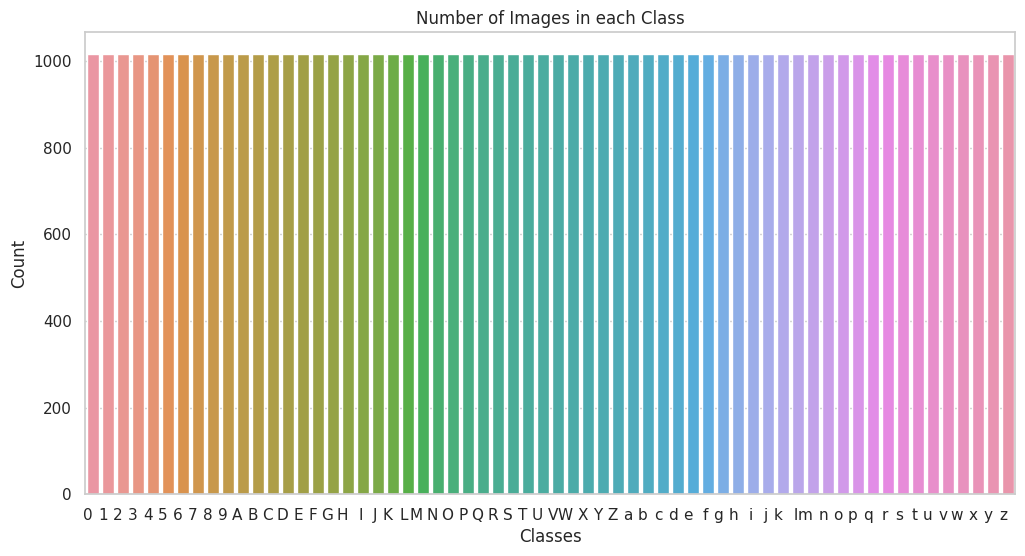

In [ ]:
def his_class_record_count(Y, classes):
  class_names_from_indices = np.vectorize(lambda x: classes[x])(np.argmax(Y, axis=1))

  # Find unique elements and their counts
  unique_elements, counts = np.unique(class_names_from_indices, return_counts=True)

  # Plot the histogram
  plt.figure(figsize=(12, 6))
  sns.barplot(x=unique_elements, y=counts)
  plt.title('Number of Images in each Class')
  plt.xlabel('Classes')
  plt.ylabel('Count')
  plt.xticks(ha='right')
  plt.show()

his_class_record_count(Y_H_E, class_names)

In [ ]:
#train_size is 1 - tst_size - vld_size
tst_size=0.15
vld_size=0.15

X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_H_E, test_size = vld_size, random_state=1024)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=tst_size, random_state=1024)

In [ ]:
print(f"Training Data Size   : {len(X_train)}")
print(f"Validation Data Size : {len(X_valid)}")
print(f"Testing Data Size    : {len(X_test)}")

Training Data Size   : 45511
Validation Data Size : 9449
Testing Data Size    : 8032


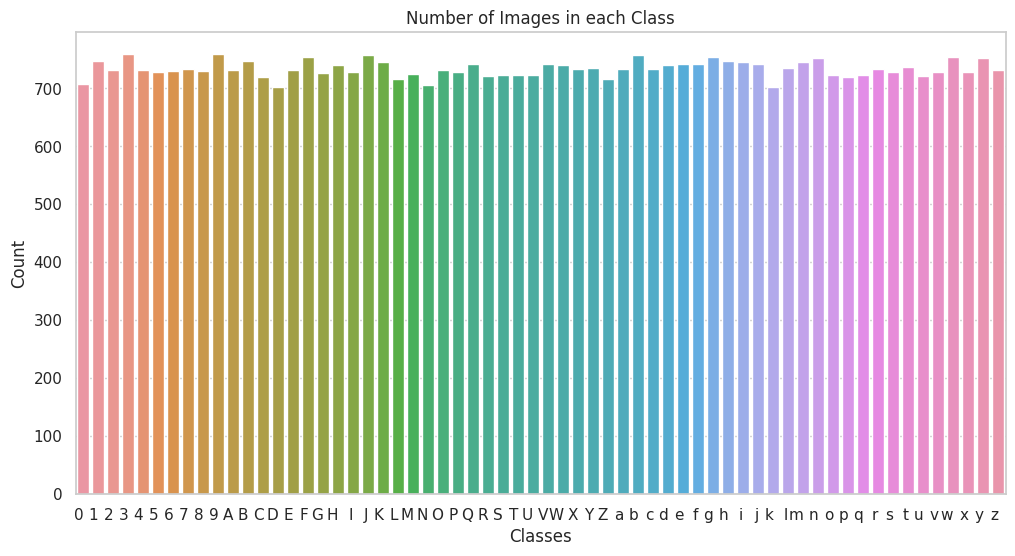

In [ ]:
his_class_record_count(y_train, class_names)

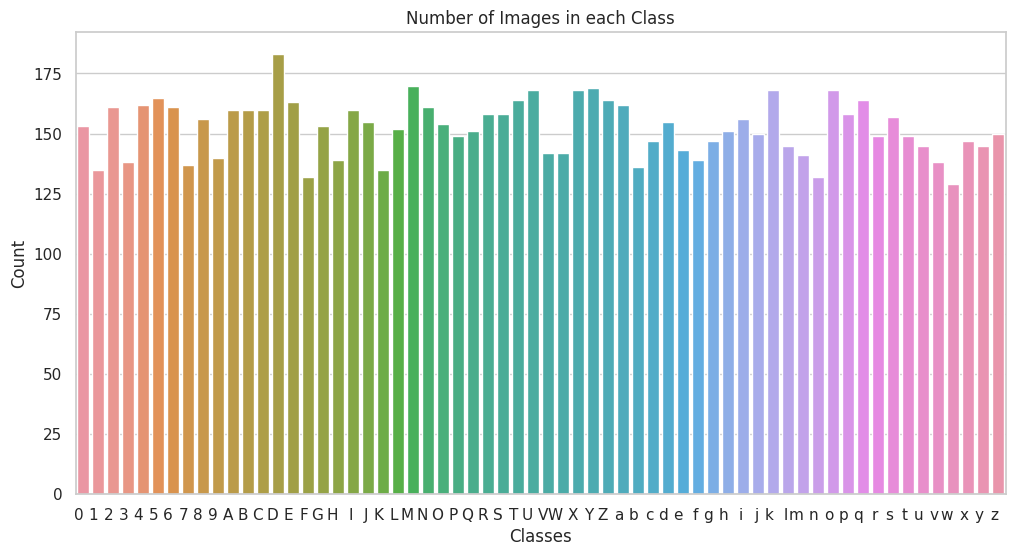

In [ ]:
his_class_record_count(y_valid, class_names)

In [ ]:
def display_images(images, labels, classes, no_of_imgs):
  indices_to_display = np.random.choice(images.shape[0], no_of_imgs, replace=False)
  # Set up the Seaborn grid layout
  sns.set(style="whitegrid")

  # Create a figure and axes to display the images
  fig, axes = plt.subplots(4, 5, figsize=(10, 8))

  for i, ax in enumerate(axes.flatten()):
    index = indices_to_display[i]
    image = images[index, :, :]

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(classes[np.argmax(labels[index])])

  plt.tight_layout()
  plt.show()

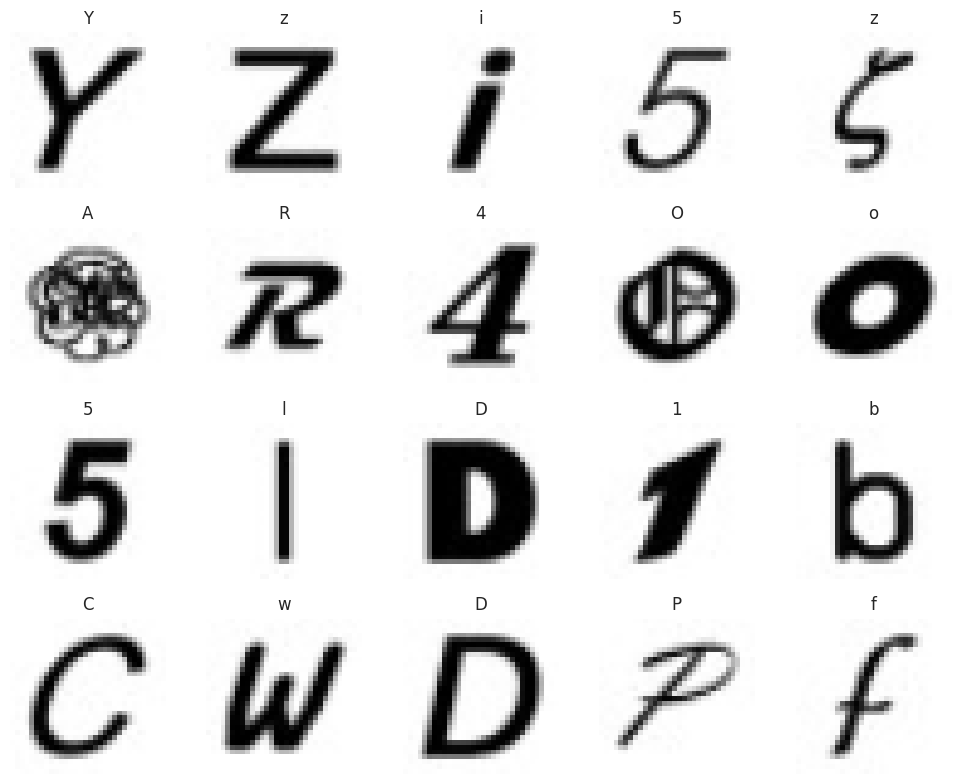

In [ ]:
display_images(X_train, y_train, class_names, 20 )

In [ ]:
def build_ResNet_model(hp):

    # Backbone
    backbone = tka.ResNet50V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
    backbone.trainable = False

    # Base Model
    model = keras.Sequential(layers=[
        layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"),
        backbone,
        layers.GlobalAveragePooling2D(name="GAP"),
        layers.Dropout(hp.Choice('0_rate', [0.2,0.3,0.4]))
    ], name='ResNet50V2')

    # Params to tweak
    for i in range(hp.Choice('n_layers', [1,2,3,4])):
        model.add(layers.Dense(hp.Choice(f'{i+1}_units', [32, 64, 128, 256]), activation='relu'))
        #model.add(layers.Dropout(hp.Choice(f'{i+1}_rate', [0.2,0.3,0.4])))
        #model.add(layers.Normalization())

    # Output layer
    model.add(layers.Dense(n_classes, activation='softmax'))

    # Compile the model.
    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        metrics=['accuracy']
    )

    return model


In [ ]:
# Initialize tuner
tuner = kt.RandomSearch(hypermodel=build_ResNet_model, objective='val_accuracy', project_name='ResNet50V2-OCR-4')

# Start hyperparameter search.
tuner.search(X_train, y_train,
             validation_data=(X_valid, y_valid),
             epochs=10,  # Adjust as needed
             batch_size=BATCH_SIZE)


Trial 10 Complete [00h 01m 58s]
val_accuracy: 0.6361519694328308

Best val_accuracy So Far: 0.7405016422271729
Total elapsed time: 00h 19m 51s


In [ ]:
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values


for key, value in best_hps.items():
    print(f"{key}: {value}")

0_rate: 0.2
n_layers: 1
1_units: 256
learning_rate: 0.001
2_units: 256
3_units: 32
4_units: 256


In [ ]:
# Get the best model and build it
best_model = tuner.get_best_models()[0]
best_model.build(input_shape=(*IMAGE_SIZE, 3))

# Best Model Summary
best_model.summary()

Model: "ResNet50V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 GAP (GlobalAveragePooling2  (None, 2048)              0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 62)                15934     
                                                                 
Total params: 24105278 (91.95 MB)
Trainable params: 540478 (2.06 MB)
Non-trainable params: 23564800 (89.89 MB)
___________

In [ ]:
# Training the model
history = best_model.fit(X_train, y_train,
                         validation_data=(X_valid, y_valid),
                         epochs=100,
                         callbacks = [
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint(f'{model_dir}model_ocr_v3_4.h5', save_best_only=True),
        callbacks.TensorBoard(f'{tensorboard_log_dir}{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}', histogram_freq=1)
    ]
)

Epoch 1/100
1420/1423 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.6987

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1423/1423 [==============================] - 27s 17ms/step - loss: 0.9867 - accuracy: 0.6988 - val_loss: 0.8905 - val_accuracy: 0.7403
Epoch 2/100
1423/1423 [==============================] - 24s 17ms/step - loss: 0.9444 - accuracy: 0.7092 - val_loss: 0.8786 - val_accuracy: 0.7417
Epoch 3/100
1423/1423 [==============================] - 24s 17ms/step - loss: 0.9184 - accuracy: 0.7169 - val_loss: 0.8733 - val_accuracy: 0.7475
Epoch 4/100
1423/1423 [==============================] - 24s 17ms/step - loss: 0.8966 - accuracy: 0.7225 - val_loss: 0.8507 - val_accuracy: 0.7509
Epoch 5/100
1423/1423 [==============================] - 22s 15ms/step - loss: 0.8758 - accuracy: 0.7290 - val_loss: 0.8602 - val_accuracy: 0.7384
Epoch 6/100
1423/1423 [==============================] - 22s 16ms/step - loss: 0.8580 - accuracy: 0.7329 - val_loss: 0.8571 - val_accuracy: 0.7442
Epoch 7/100
1423/1423 [==============================] - 24s 17ms/step - loss: 0.8450 - accuracy: 0.7363 - val_loss: 0.8469 - val_

In [ ]:
# Valid Data
score = best_model.evaluate(X_valid, y_valid)

print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

296/296 [==============================] - 3s 11ms/step - loss: 0.7846 - accuracy: 0.7765
Validation loss: 0.7845628261566162
Validation accuracy: 0.7764843106269836


In [ ]:
# Test data
score = best_model.evaluate(X_test, y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

251/251 [==============================] - 3s 12ms/step - loss: 0.7913 - accuracy: 0.7745
Test loss: 0.7913343906402588
Test accuracy: 0.7745268940925598


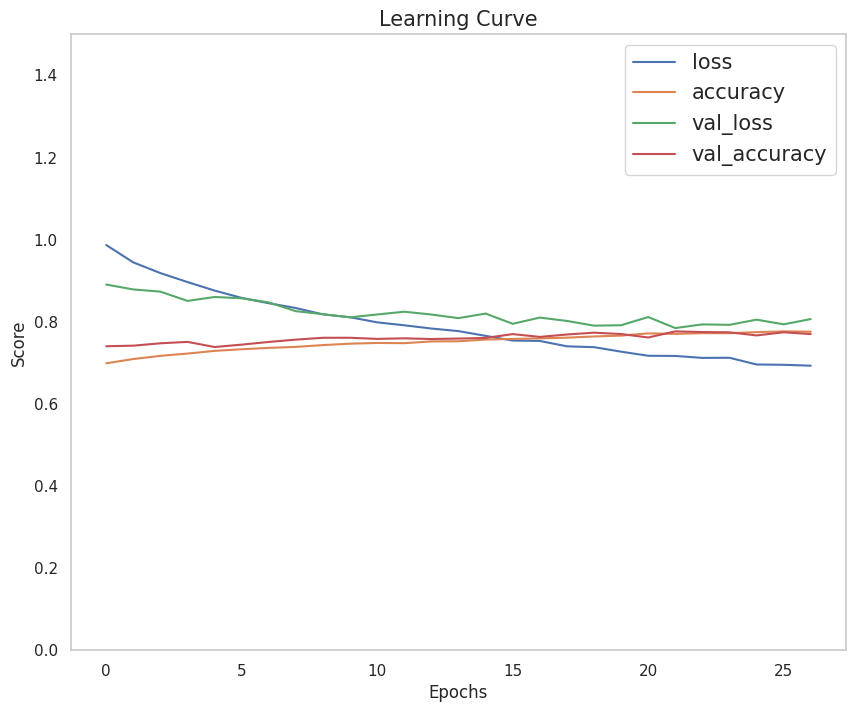

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=15)
plt.legend(fontsize=15)
plt.ylim([0,1.5])
plt.ylabel('Score')
plt.xlabel('Epochs')
plt.grid()
plt.show()

In [ ]:
# All the backbones will be accessed through a name.
BACKBONE_NAMES = [
    #'ResNet50V2',
    #'ResNet101V2',
    #'ResNet152V2',
    #'VGG16',
    'VGG19',
    'MobileNet'
]

In [ ]:
# Load the backbones
BACKBONES = [
    #tka.ResNet50V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    #tka.ResNet101V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    #tka.ResNet152V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    #tka.VGG16(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.VGG19(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
]

for backbone in BACKBONES:
    backbone.trainable = False

    # no_of_layers = len(backbone.layers)
    # no_of_layers = int(no_of_layers)
    # no_of_layers = (no_of_layers * 95) // 100

    # # Freeze all the layers before the `fine_tune_at` layer
    # for layer in backbone.layers[:no_of_layers]:
    #   layer.trainable =  False

80134624/80134624 [==============================] - 2s 0us/step


17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
# store the Backbone histories.
BACKBONE_HISTORIES = []

# Iterate over the backbones
for name, backbone in zip(BACKBONE_NAMES, BACKBONES):

    # Show
    print(f'BACKBONE : {name.title()}\n')

    # Create a simple model architecture.
    dummy_model = keras.Sequential(layers=[
        layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"),
        backbone,
        layers.GlobalAveragePooling2D(name="GAP"),
        layers.Dropout(0.2, name="DropoutLayer"),
        layers.Dense(256, activation='relu'),
        layers.Dense(n_classes, activation='softmax', name="OutputLayer")
    ], name=name.strip().title())

    # Show the summary
    print('-'*100)
    print("Model Summary\n")
    dummy_model.summary()
    print("\n")
    print('-'*100)

    # Compile the model.
        # Compile the model.
    dummy_model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(1e-3),
        metrics=['accuracy']
    )


    # Train the model
    print("\n")
    print('-'*100)
    print("Model Training\n")
    #history = dummy_model.fit(train_ds, validation_data=test_ds, epochs=10)
    # Training the model
    history = dummy_model.fit(X_train, y_train,
                         validation_data=(X_valid, y_valid),
                         epochs=100,
                         callbacks = [
        callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        callbacks.ModelCheckpoint(f'{model_dir}model_ocr_{name.strip()}_v1.h5', save_best_only=True),
        callbacks.TensorBoard(f'{tensorboard_log_dir}{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}', histogram_freq=1)
    ]
)
    print("\n")
    print('-'*100)

    # Store the history
    BACKBONE_HISTORIES.append(
        pd.DataFrame(history.history)
    )

    # clear the output.
    #cls()

BACKBONE : Vgg19

----------------------------------------------------------------------------------------------------
Model Summary

Model: "Vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 GAP (GlobalAveragePooling2  (None, 512)               0         
 D)                                                              
                                                                 
 DropoutLayer (Dropout)      (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 OutputLayer (Dense)         (None, 62)                15934     
                                                           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1423/1423 [==============================] - 14s 8ms/step - loss: 3.6768 - accuracy: 0.0940 - val_loss: 3.3472 - val_accuracy: 0.1537
Epoch 2/100
1423/1423 [==============================] - 11s 8ms/step - loss: 3.4280 - accuracy: 0.1353 - val_loss: 3.2259 - val_accuracy: 0.1725
Epoch 3/100
1423/1423 [==============================] - 11s 8ms/step - loss: 3.3241 - accuracy: 0.1559 - val_loss: 3.2175 - val_accuracy: 0.1680
Epoch 4/100
1423/1423 [==============================] - 11s 8ms/step - loss: 3.2693 - accuracy: 0.1637 - val_loss: 3.2082 - val_accuracy: 0.1740
Epoch 5/100
1423/1423 [==============================] - 11s 8ms/step - loss: 3.2362 - accuracy: 0.1698 - val_loss: 3.1869 - val_accuracy: 0.1798
Epoch 6/100
1423/1423 [==============================] - 10s 7ms/step - loss: 3.2102 - accuracy: 0.1737 - val_loss: 3.1735 - val_accuracy: 0.1793
Epoch 7/100
1423/1423 [==============================] - 11s 8ms/step - loss: 3.1950 - accuracy: 0.1784 - val_loss: 3.2156 - val_accurac

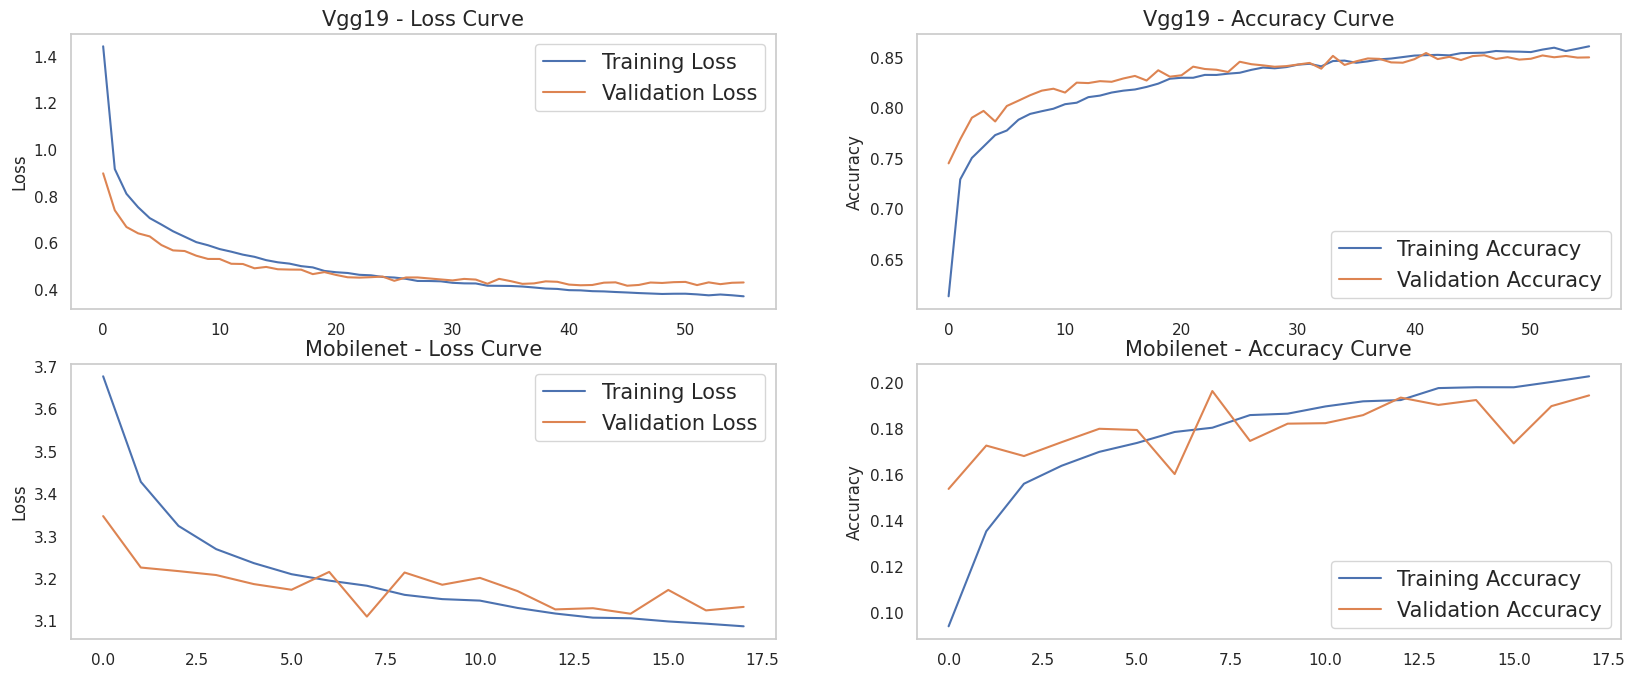

In [ ]:
# Plotting configurations
plt.figure(figsize=(20, 25))

# Iterate over the backbone histories.
index = 1
for name, history in zip(BACKBONE_NAMES, BACKBONE_HISTORIES):

    # subplot of the Backbone Learning curve.
    plt.subplot(6, 2, index)
    plt.title(name.strip().title() + " - Loss Curve", fontsize=15)
    plt.plot(history['loss'], label="Training Loss")
    plt.plot(history['val_loss'], label="Validation Loss")
    plt.ylabel("Loss")
    plt.legend(fontsize=15)
    plt.grid()

    plt.subplot(6, 2, index+1)
    plt.title(name.strip().title() + " - Accuracy Curve", fontsize=15)
    plt.plot(history['accuracy'], label="Training Accuracy")
    plt.plot(history['val_accuracy'], label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.legend(fontsize=15)
    plt.grid()

    # update index
    index+=2

# show the final plot.
plt.savefig(f'{figure_dir}BackboneComparision-All.png')
plt.show()

In [ ]:
def build_model(hp):

  # Initialize the model in sequential
  model = keras.Sequential()
  # Adding first convolutional layer
  model.add(layers.Conv2D(
      filters=hp.Int('conv_1_filter', min_value=64, max_value=256, step=64),
      kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
      activation='relu',
      input_shape=(*IMAGE_SIZE,3)
  ))
  # Adding first pooling layer
  model.add(layers.MaxPool2D(
      pool_size=(hp.Int('pool_1_size', min_value=2, max_value=3, step=1),
      hp.Int('pool_1_size', min_value=2, max_value=3, step=1))
  ))

  # Adding multiple convolutional and pooling layers
  for i in range(hp.Choice('n_conv_layers', values=[1,2,4])):
    model.add(layers.Conv2D(
        filters=hp.Int(f'conv_{i+2}_filter', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice(f'conv_{i+2}_kernel', values=[3,5]),
        activation='relu',
    ))
    model.add(layers.MaxPool2D(
        pool_size=(hp.Int(f'pool_{i+2}_size', min_value=2, max_value=3, step=1),
        hp.Int(f'pool_{i+1}_size', min_value=2, max_value=3, step=1))
    ))

  model.add(layers.GlobalAveragePooling2D())

  # Adding multiple FC layers
  for i in range(hp.Int('n_FC_layers', min_value=1, max_value=2, step=1)):
    model.add(layers.Dense(hp.Choice(f'{i+1}_FC_layer', values=[64, 128, 256]),
                           activation='relu'))
    model.add(layers.Dropout(hp.Choice(f'{i+1}_dropout_layer', values=[0.2, 0.3, 0.5])))
  #model.add(layers.BatchNormalization())

  # Adding output layer
  model.add(layers.Dense(n_classes, activation='softmax'))


  # Compile the model
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                metrics=['accuracy'])


  return model


In [ ]:
# Initialize tuner
tuner = kt.RandomSearch(hypermodel=build_model, objective='val_accuracy', project_name='ResNet50V2-OCR-5')

# Start hyperparameter search.
tuner.search(X_train, y_train,
             validation_data=(X_valid, y_valid),
             epochs=10,  # Adjust as needed
             batch_size=BATCH_SIZE)

Trial 10 Complete [00h 03m 55s]
val_accuracy: 0.016933009028434753

Best val_accuracy So Far: 0.8351148366928101
Total elapsed time: 00h 26m 39s


In [ ]:
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values


for key, value in best_hps.items():
    print(f"{key}: {value}")

conv_1_filter: 128
conv_1_kernel: 3
pool_1_size: 2
n_conv_layers: 2
conv_2_filter: 64
conv_2_kernel: 5
pool_2_size: 3
n_FC_layers: 1
1_FC_layer: 128
1_dropout_layer: 0.5
learning_rate: 0.001
conv_3_filter: 64
conv_3_kernel: 3
pool_3_size: 3
conv_4_filter: 64
conv_4_kernel: 3
2_FC_layer: 256
2_dropout_layer: 0.5


In [ ]:
# Get the best model and build it
best_model = tuner.get_best_models()[0]
best_model.build(input_shape=(*IMAGE_SIZE, 3))

# Best Model Summary
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 13, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 11, 64)         36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 3, 64)          0

In [ ]:
# Training the model
history = best_model.fit(X_train, y_train,
                         validation_data=(X_valid, y_valid),
                         epochs=100,
                         callbacks = [
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint(f'{model_dir}model_ocr_v4.h5', save_best_only=True),
        callbacks.TensorBoard(f'{tensorboard_log_dir}{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}', histogram_freq=1)
    ]
)

Epoch 1/100
1423/1423 [==============================] - 20s 13ms/step - loss: 0.6375 - accuracy: 0.7858 - val_loss: 0.4855 - val_accuracy: 0.8307
Epoch 2/100
   1/1423 [..............................] - ETA: 17s - loss: 0.5480 - accuracy: 0.7812

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1423/1423 [==============================] - 17s 12ms/step - loss: 0.5935 - accuracy: 0.7973 - val_loss: 0.4690 - val_accuracy: 0.8274
Epoch 3/100
1423/1423 [==============================] - 16s 12ms/step - loss: 0.5720 - accuracy: 0.8008 - val_loss: 0.4723 - val_accuracy: 0.8351
Epoch 4/100
1423/1423 [==============================] - 17s 12ms/step - loss: 0.5485 - accuracy: 0.8080 - val_loss: 0.4563 - val_accuracy: 0.8378
Epoch 5/100
1423/1423 [==============================] - 17s 12ms/step - loss: 0.5304 - accuracy: 0.8123 - val_loss: 0.4413 - val_accuracy: 0.8386
Epoch 6/100
1423/1423 [==============================] - 17s 12ms/step - loss: 0.5189 - accuracy: 0.8169 - val_loss: 0.4350 - val_accuracy: 0.8433
Epoch 7/100
1423/1423 [==============================] - 17s 12ms/step - loss: 0.5008 - accuracy: 0.8220 - val_loss: 0.4333 - val_accuracy: 0.8455
Epoch 8/100
1423/1423 [==============================] - 17s 12ms/step - loss: 0.4837 - accuracy: 0.8257 - val_loss: 0.4280 - val_

In [ ]:
# Valid Data
score = best_model.evaluate(X_valid, y_valid)

print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

296/296 [==============================] - 1s 4ms/step - loss: 0.3782 - accuracy: 0.8586
Validation loss: 0.3782087564468384
Validation accuracy: 0.8586093783378601


In [ ]:
# Test data
score = best_model.evaluate(X_test, y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

251/251 [==============================] - 1s 4ms/step - loss: 0.3729 - accuracy: 0.8653
Test loss: 0.37293919920921326
Test accuracy: 0.8652888536453247


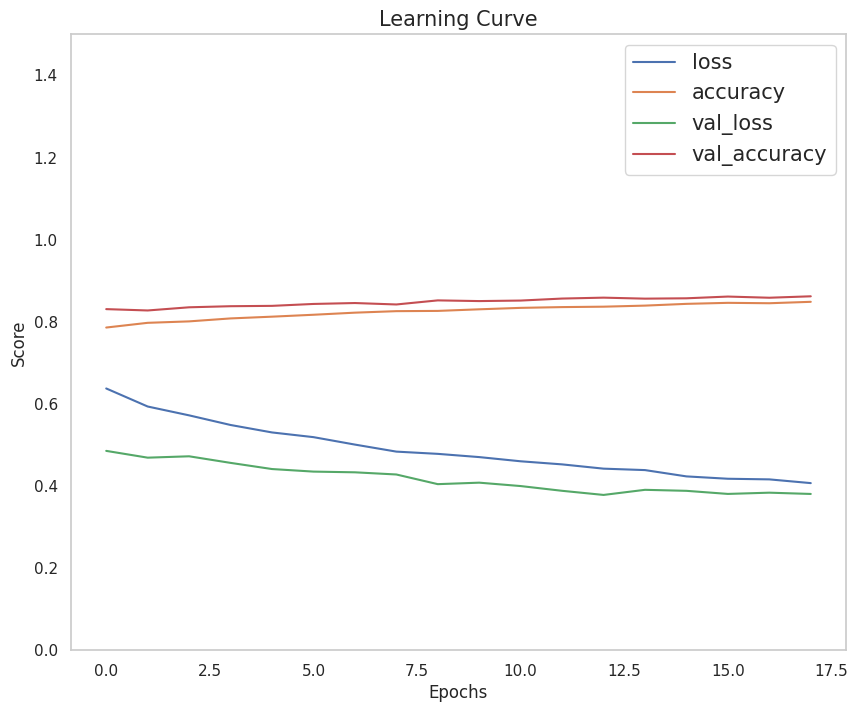

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=15)
plt.legend(fontsize=15)
plt.ylim([0,1.5])
plt.ylabel('Score')
plt.xlabel('Epochs')
plt.grid()
plt.show()

(64, 64, 3)


<ipython-input-96-2b6ebdb392b7>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)


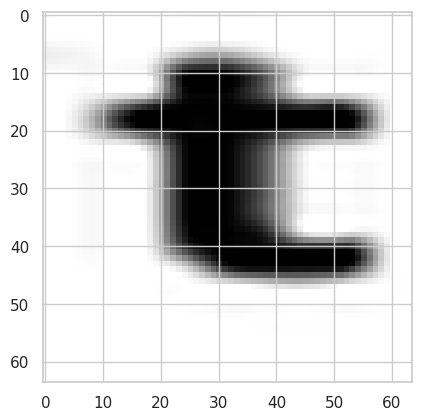

In [ ]:

img = Image.open('/content/gdrive/MyDrive/OWR/data/tmpCharacterSegment2/character_11.png')

 # Resize image
img = img.resize(IMAGE_SIZE, Image.ANTIALIAS)

# Convert to NumPy array
img_array = np.array(img)

# Normalize by dividing by 255
img_array = img_array / 255.0
print(img_array.shape)
plt.imshow(img_array)



In [ ]:
image = tf.expand_dims(img_array, axis=0)
pred = best_model.predict(image)[0]
max_index = tf.argmax(pred)
score = pred[max_index]
pred_label = class_names[max_index]
print(pred_label)

1/1 [==============================] - 0s 17ms/step
z


**++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++**
# Following Section is to troubleshoot the errors observed

In [6]:
#model_path = '/content/gdrive/MyDrive/OWR/dl_models/OCR_Model3/model_ocr_VGG19_v1.h5'
model_path = '/content/gdrive/MyDrive/OWR/dl_models/OCR_Model3/model_ocr_v4.h5'
model_verification = keras.models.load_model(model_path)

model_verification.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 13, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 11, 64)         36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 3, 64)          0

In [70]:
#img = Image.open('/content/gdrive/MyDrive/OWR/data/tmpCharacterSegment3/character_13.png')
img = cv2.imread('/content/gdrive/MyDrive/OWR/data/tmpCharacterSegment3/character_16.png', cv2.IMREAD_GRAYSCALE)

 # Resize image
#img = img.resize((64,64), Image.ANTIALIAS)
img = cv2.resize(img, (64, 64))
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Convert to NumPy array
img_array = np.array(img)

# Normalize by dividing by 255
img_array = img_array / 255.0
print(img_array.shape)
plt.imshow(img_array, cmap='gray')

error: ignored

In [69]:
image = tf.expand_dims((img_array), axis=0)
pred = model_verification.predict(image)[0]
max_index = tf.argmax(pred)
score = pred[max_index]
pred_label = class_names[max_index]
print(pred_label)

1/1 [==============================] - 0s 46ms/step
S


In [ ]:
def display_images_test(images, labels, classes, start_pos, end_pos, model):
  #indices_to_display = np.random.choice(images.shape[0], no_of_imgs, replace=False)
  # Set up the Seaborn grid layout
  #sns.set(style="whitegrid")

  rows = ((end_pos - start_pos) // 15) + 1



  # Create a figure and axes to display the images
  fig, axes = plt.subplots(rows, 15, figsize=(20, 10))

  #plt.clf()
  plt.cla()
  #plt.close()

  ErrorList = []
  indices_to_display = start_pos
  for i, ax in enumerate(axes.flatten()):
    index = indices_to_display
    image = images[index, :, :]

    image1 = tf.expand_dims(image, axis=0)
    pred = model.predict(image1)[0]
    max_index = tf.argmax(pred)
    score = pred[max_index]
    pred_label = classes[max_index]

    cls()

    if (pred_label != classes[labels[index]]):
      inndexT = str(index)
      ErrorList.append(index)


    else: inndexT = ''

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'O:{classes[labels[index]]} P:{pred_label}{inndexT}')


    indices_to_display += 1

  plt.tight_layout()
  plt.show()
  plt.clf()
  plt.cla()
  plt.close()

  return ErrorList


In [ ]:
def display_images_test2(images, labels, classes, start_pos, end_pos, model):
  #indices_to_display = np.random.choice(images.shape[0], no_of_imgs, replace=False)
  # Set up the Seaborn grid layout
  #sns.set(style="whitegrid")

  #rows = ((end_pos - start_pos) // 15) + 1



  # Create a figure and axes to display the images
  plt.figure(figsize=(100, 500))

  plt.clf()
  plt.cla()
  #plt.close()

  ErrorList = []
  indices_to_display = 1
  for i in range(start_pos,end_pos):
    index = i
    image = images[index, :, :]

    image1 = tf.expand_dims(image, axis=0)
    pred = model.predict(image1)[0]
    max_index = tf.argmax(pred)
    score = pred[max_index]
    pred_label = classes[max_index]

    cls()

    if (pred_label != classes[labels[index]]):
      inndexT = str(index)
      ErrorList.append(index)

      plt.subplot(100, 15, indices_to_display)
      plt.imshow(image)
      plt.title(f'O:{classes[labels[index]]} P:{pred_label}{inndexT}')
      plt.axis('off')

      indices_to_display += 1



  plt.tight_layout()
  plt.show()
  plt.clf()
  plt.cla()
  plt.close()

  return ErrorList


In [ ]:
target = 1

# Find the first position
first_position = np.where(y_train == target)[0][0] if target in y_train else -1

# Find the last position
#last_position = first_position + 120
last_position = np.where(y_train == target)[0][-1] if target in y_train else -1

#print(first_position, last_position)
start_point = first_position
start_point = start_point
end_point  = first_position + 120

E_List = display_images_test(X_train, y_train, class_names, start_point, end_point, model_verification)

#print(E_List)


#print(first_position, last_position)

#print(y_train[50000:50010])

#print(type(y_train))

#print(X_train[0].shape)

In [ ]:
print(len(y_train))

62992


In [ ]:

# Find the first position
first_position = 1000

# Find the last position
#last_position = first_position + 120
last_position = 5000

#print(first_position, last_position)
start_point = first_position
start_point = start_point
end_point  = last_position

E_List = display_images_test2(X_train, y_train, class_names, start_point, end_point, model_verification)

#print(E_List)

In [ ]:
print(E_List)

[1000, 1001, 1002, 1004, 1005, 1006, 1007, 1016, 1018, 1019, 1032, 1036, 1086, 1124, 1125, 1126, 1127, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1138, 1184, 1185, 1186, 1187, 1208, 1210, 1211, 1216, 1218, 1224, 1230, 1288, 1310, 1311, 1312, 1313, 1315, 1328, 1329, 1330, 1331, 1352, 1353, 1354, 1355, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1440, 1462, 1466, 1467, 1488, 1489, 1490, 1491, 1502, 1596, 1598, 1608, 1609, 1610, 1611, 1624, 1626, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1796, 1798, 1818, 1828, 1832, 1872, 1874, 1876, 1888, 1890, 1948, 1949, 1950, 1956, 1970, 1974, 1990, 1992, 1994, 2008, 2010, 2243, 2263, 2324, 2327, 2519, 2784, 2806, 2807, 2875, 2904, 2905, 2960, 2961, 3039, 3341, 3343, 3510, 3578, 3579, 3924, 3926, 3979, 4132, 4137, 4168, 4171, 4180, 4356, 4358, 4359, 4548, 4550, 4551, 4594, 4595, 4909, 4940, 4942, 4963]


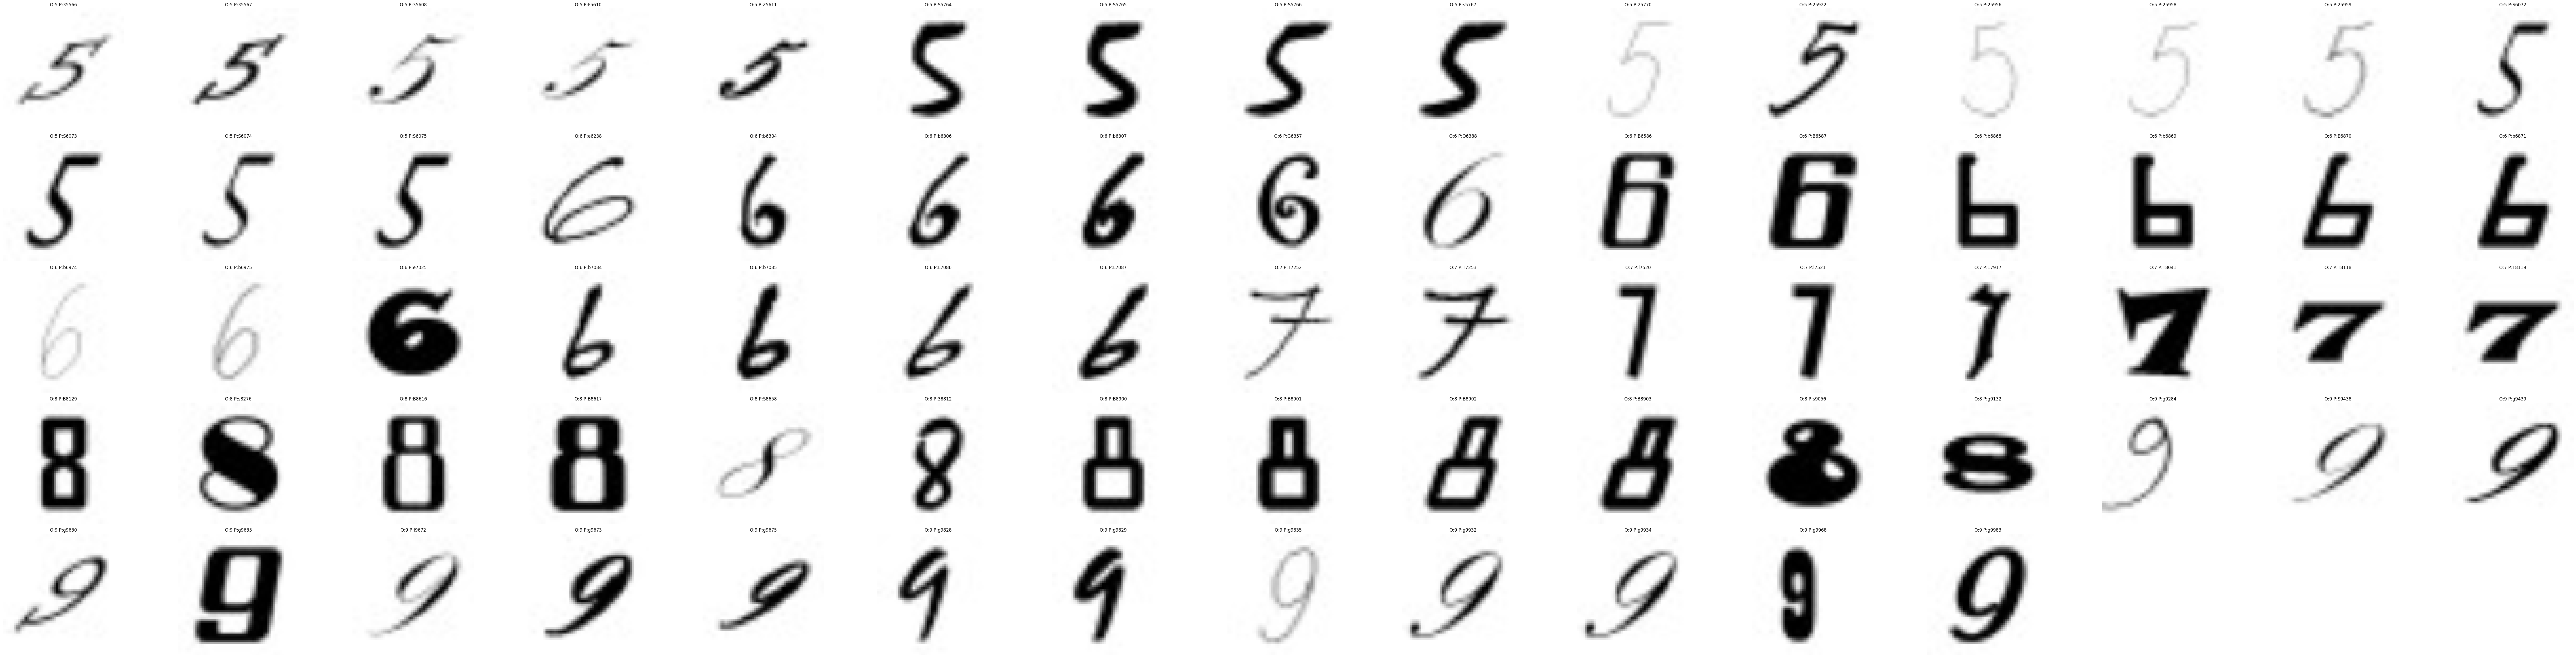

In [ ]:

# Find the first position
first_position = 5000

# Find the last position
#last_position = first_position + 120
last_position = 10000

#print(first_position, last_position)
start_point = first_position
start_point = start_point
end_point  = last_position

E_List = display_images_test2(X_train, y_train, class_names, start_point, end_point, model_verification)



In [ ]:
print(E_List)

[5566, 5567, 5608, 5610, 5611, 5764, 5765, 5766, 5767, 5770, 5922, 5956, 5958, 5959, 6072, 6073, 6074, 6075, 6238, 6304, 6306, 6307, 6357, 6388, 6586, 6587, 6868, 6869, 6870, 6871, 6974, 6975, 7025, 7084, 7085, 7086, 7087, 7252, 7253, 7520, 7521, 7917, 8041, 8118, 8119, 8129, 8276, 8616, 8617, 8658, 8812, 8900, 8901, 8902, 8903, 9056, 9132, 9284, 9438, 9439, 9630, 9635, 9672, 9673, 9675, 9828, 9829, 9835, 9932, 9934, 9968, 9983]


In [ ]:

# Find the first position
first_position = 10000

# Find the last position
#last_position = first_position + 120
last_position = 15000

#print(first_position, last_position)
start_point = first_position
start_point = start_point
end_point  = last_position

E_List = display_images_test2(X_train, y_train, class_names, start_point, end_point, model_verification)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(E_List)

[10035, 10132, 10133, 10134, 10148, 10149, 10150, 10151, 10171, 10264, 10265, 10266, 10267, 10310, 10420, 10422, 10423, 10452, 10453, 10457, 10540, 10544, 10545, 10546, 10547, 10592, 10593, 10594, 10595, 10620, 10686, 10688, 10689, 10690, 10772, 10773, 10774, 10775, 10941, 10949, 10951, 10965, 10966, 10967, 11056, 11058, 11059, 11089, 11091, 11156, 11280, 11281, 11283, 11317, 11386, 11470, 11471, 11576, 11677, 11707, 11955, 11978, 11981, 11982, 11983, 12052, 12054, 12055, 12195, 12196, 12197, 12198, 12199, 12203, 12205, 12207, 12223, 12224, 12225, 12226, 12227, 12235, 12237, 12239, 12243, 12259, 12265, 12266, 12267, 12268, 12269, 12270, 12271, 12274, 12275, 12277, 12279, 12298, 12299, 12323, 12325, 12327, 12331, 12334, 12335, 12339, 12347, 12351, 12352, 12353, 12354, 12355, 12359, 12367, 12393, 12403, 12407, 12408, 12409, 12411, 12415, 12417, 12419, 12420, 12421, 12422, 12423, 12427, 12429, 12430, 12431, 12449, 12451, 12453, 12454, 12455, 12469, 12471, 12473, 12475, 12484, 12485, 12486

In [ ]:

# Find the first position
first_position = 15000

# Find the last position
#last_position = first_position + 120
last_position = 20000

#print(first_position, last_position)
start_point = first_position
start_point = start_point
end_point  = last_position

E_List = display_images_test2(X_train, y_train, class_names, start_point, end_point, model_verification)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(E_List)

[15000, 15001, 15002, 15003, 15013, 15015, 15028, 15029, 15030, 15031, 15096, 15097, 15102, 15103, 15202, 15217, 15219, 15391, 15500, 15501, 15532, 15534, 15672, 15673, 15726, 15727, 15768, 15770, 15798, 15799, 15871, 16028, 16030, 16045, 16047, 16093, 16119, 16180, 16181, 16182, 16183, 16237, 16238, 16239, 16244, 16245, 16257, 16328, 16329, 16330, 16331, 16377, 16396, 16398, 16405, 16407, 16416, 16417, 16418, 16419, 16516, 16549, 16550, 16551, 16592, 16594, 16639, 16640, 16641, 16657, 16680, 16681, 16684, 16709, 16711, 16760, 16784, 16785, 16786, 16836, 16848, 16864, 16874, 16875, 16940, 16941, 16942, 16943, 17008, 17009, 17010, 17011, 17014, 17035, 17044, 17046, 17056, 17057, 17058, 17060, 17062, 17063, 17081, 17083, 17132, 17133, 17134, 17135, 17144, 17146, 17154, 17155, 17196, 17197, 17198, 17199, 17245, 17246, 17254, 17255, 17260, 17261, 17262, 17263, 17386, 17387, 17420, 17421, 17422, 17565, 17566, 17567, 17570, 17571, 17657, 17659, 17707, 17727, 17758, 17759, 17800, 17801, 17802

In [ ]:
start_point = end_point
end_point  = end_point + 120

E_List = display_images_test(X_train, y_train, class_names, start_point, end_point, model_verification)

print(E_List)



In [ ]:
start_point = end_point
end_point  = end_point + 120

E_List = display_images_test(X_train, y_train, class_names, start_point, end_point, model_verification)

print(E_List)




In [ ]:
start_point = end_point
end_point  = end_point + 120

E_List = display_images_test(X_train, y_train, class_names, start_point, end_point, model_verification)

print(E_List)




In [ ]:
start_point = end_point
end_point  = end_point + 120

E_List = display_images_test(X_train, y_train, class_names, start_point, end_point, model_verification)

print(E_List)



In [ ]:
start_point = end_point
end_point  = end_point + 120

E_List = display_images_test(X_train, y_train, class_names, start_point, end_point, model_verification)

print(E_List)



In [ ]:
start_point = end_point
end_point  = end_point + 120

E_List = display_images_test(X_train, y_train, class_names, start_point, end_point, model_verification)

print(E_List)



In [ ]:
start_point = end_point
end_point  = end_point + 120

E_List = display_images_test(X_train, y_train, class_names, start_point, end_point, model_verification)

print(E_List)

In [ ]:
start_point = end_point
end_point  = end_point + 120

E_List = display_images_test(X_train, y_train, class_names, start_point, end_point, model_verification)

print(E_List)

In [ ]:
image = tf.expand_dims(X_train[first_position], axis=0)
pred = model_verification.predict(image)[0]
max_index = tf.argmax(pred)
score = pred[max_index]
pred_label = class_names[max_index]
print(pred_label)

1/1 [==============================] - 0s 122ms/step
2


In [ ]:
num1 = 104000

num = num1 // 100

print(num)

1040
